In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

1. взять любой набор данных для бинарной классификации.

Я взял вот этот датасет с kaggle: https://www.kaggle.com/c/choose-tutors/data

2. сделать обзорный анализ выбранного датасета

**Загрузим train и test датасеты**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


**EDA**

In [4]:
df = pd.read_csv('train.csv')
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


Пропусков в данных нет

In [6]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


Значения выглядят нормальными, очевидных выбросов нет

**Посмотрим на распределение целевой переменной**

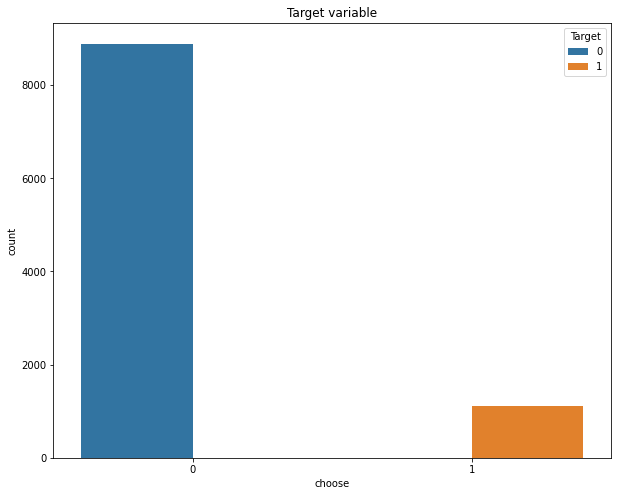

In [7]:
plt.figure(figsize=(10, 8))

sns.countplot(x="choose", hue="choose", data=df)
plt.title('Target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Видим явный дисбаланс классов. Объектов класса 1 в 8 раз меньше объектов класса 0.

**Корреляционный анализ**

In [8]:
TARGET_NAME = 'choose'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

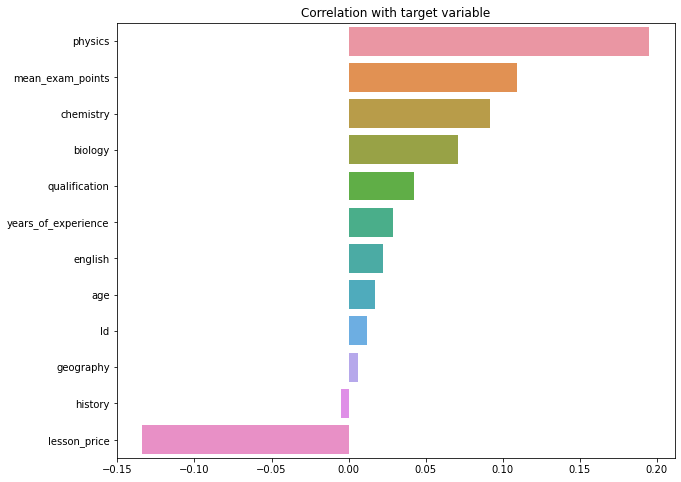

In [9]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Корреляция признаков с целевой переменной практически отсутствует. Максимальное значение по модулю не превышает 0.2, что говорит об отсутствии линейной связи между признаками и целевой переменной.

**Посмотрим графики распределения признаков**

In [10]:
df_num_features = df.select_dtypes(include = ['int64', 'float64'])
df_num_features.drop(['Id'], axis=1, inplace=True)

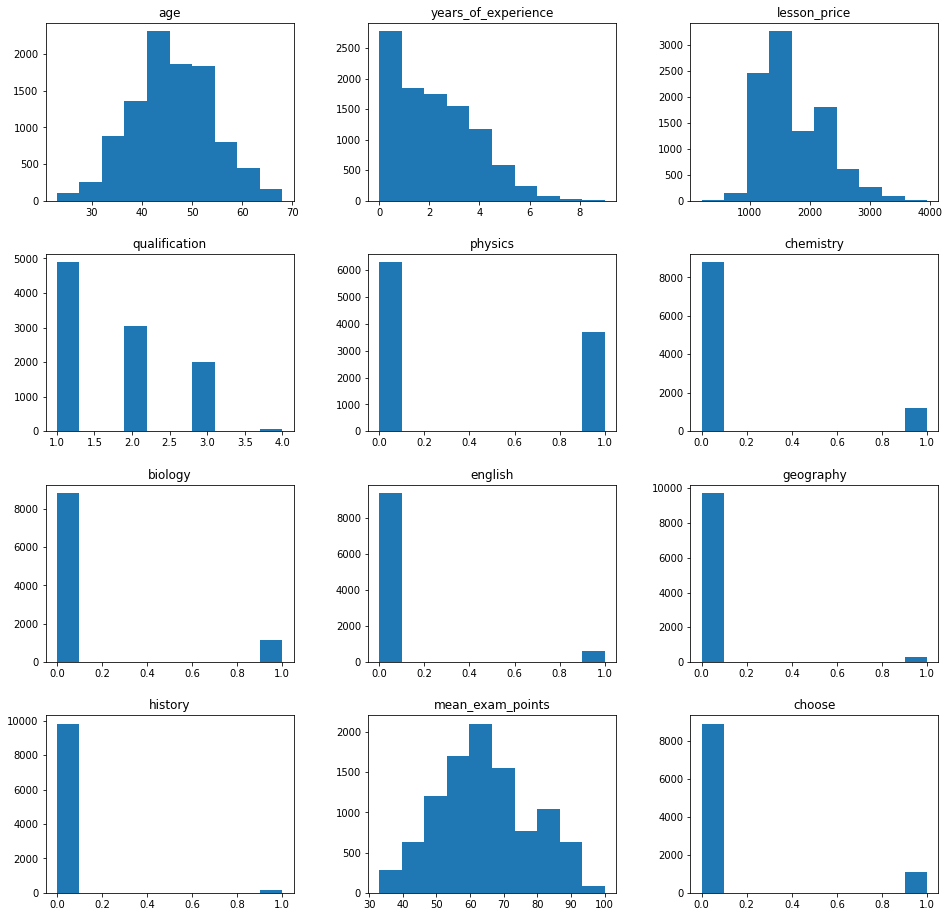

In [11]:
df_num_features.hist(figsize=(16,16), bins=10, grid=False);

Распределие вещественных признаков age, mean_exam_points - близко к нормальному. lesson_price тоже близок к нормальному распределению, но мода смещена влево. Признак years_of_experience распределен экспоненциально.

**Посмотрим на тестовый датасет**

In [12]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [13]:
df_test.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,45.924500,1.985700,1699.910000,1.702300,0.372100,0.128100,0.115800,0.049000,0.029200,0.015100,64.149400
std,2886.89568,8.031977,1.771217,526.260094,0.789644,0.483389,0.334218,0.320001,0.215879,0.168375,0.121957,13.570096
min,10000.00000,23.000000,0.000000,300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,12499.75000,41.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,14999.50000,46.000000,2.000000,1550.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,17499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,19999.00000,68.000000,9.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98.000000


средние значения и стандартные отклонения принаков близки к train. Датасеты очень похожи.

Посмотрим графики распределения признаков

In [14]:
df_test_num_features = df_test.select_dtypes(include = ['int64', 'float64'])
df_test_num_features.drop(['Id'], axis=1, inplace=True)

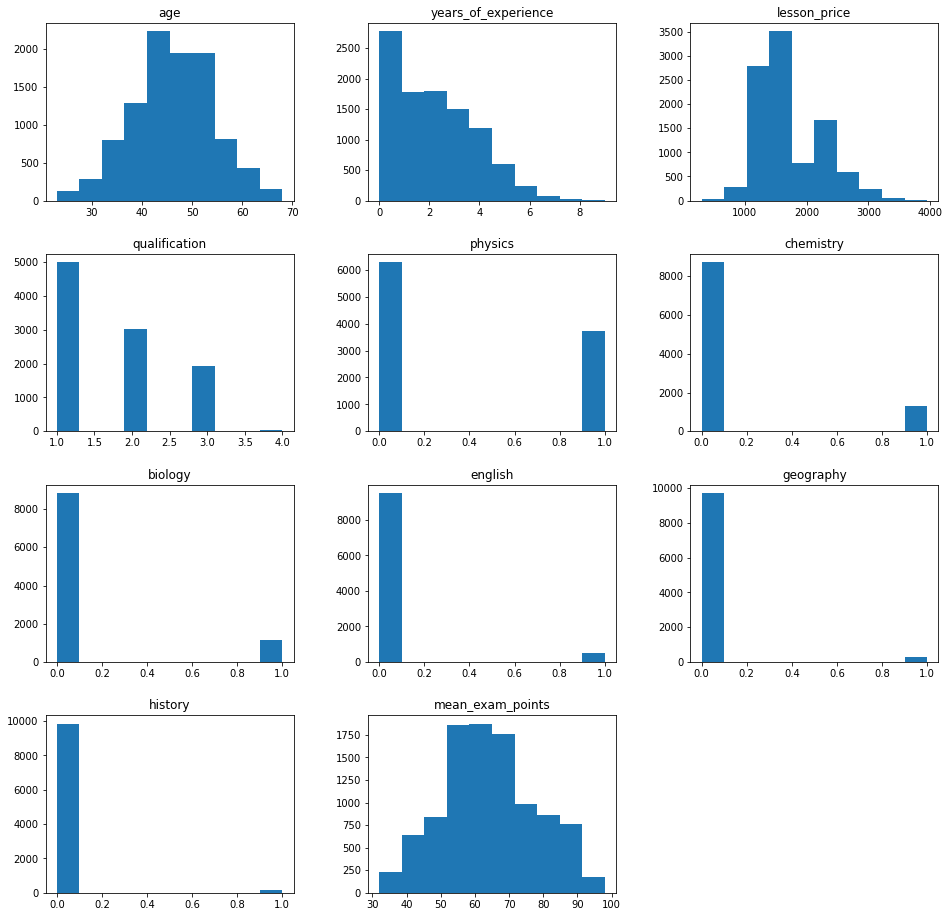

In [15]:
df_test_num_features.hist(figsize=(16,16), bins=10, grid=False);

Распределения признаков test датасета очень похожи на распределения признаков в train. Небольшое отличие в распределении по признаку mean_exam_points. В целом датасеты очень похожи.

#3. сделать feature engineering

**Функция создания новых фич в датасете**

In [16]:
def new_features(df):

    #feature 1 - дамми, где единицей помечены репетиторы только по математике (без дополнительных предметов)
    zero_add_subjects = df[(df['chemistry']==0) & (df['biology']==0) & (df['physics']==0) & (df['english']==0)
          & (df['geography']==0) & (df['history']==0)]
    df['new_feature_1'] = pd.Series(np.zeros(df.shape[0]), index=df.index)
    df.loc[zero_add_subjects.index, 'new_feature_1'] = 1

    """feature 2 - относительная метрика: отношение стоимости часа к 
    среднему значению баллов ученика"""
    new_feature_2 = df['lesson_price']/df['mean_exam_points']
    df['new_feature_2'] = pd.Series(new_feature_2, index=df.index)

    """feature 3 - относительная метрика: отношение стоимости часа к 
    количеству лет опыта + 1 (чтобы избежать деления на 0)"""
    new_feature_3 = df['lesson_price'] / (df['years_of_experience'] + 1)
    df['new_feature_3'] = pd.Series(new_feature_3, index=df.index)

    """feature 4 - относительная метрика: отношение стоимости часа к 
    уровню квалификации"""
    new_feature_4 = df['lesson_price'] / df['qualification']
    df['new_feature_4'] = pd.Series(new_feature_4, index=df.index)

    return df

Добавим новые признаки в тестовый и трейновый датасеты

In [17]:
df = new_features(df)
df_test = new_features(df_test)

Разобьем трейн на обучающую и валидационную выборки

In [18]:
X = df.drop(['choose'], axis=1)
y = df['choose']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,stratify=y, random_state=86)
X_train.shape, X_test.shape

((8000, 16), (2000, 16))

#4. обучить любой классификатор (какой вам нравится)

In [20]:
!pip install catboost

     |████████████████████████████████| 69.2MB 46kB/s 


In [32]:
import catboost as cb
from sklearn.model_selection import GridSearchCV
from catboost import Pool

catb = cb.CatBoostClassifier(verbose=False, use_best_model=True, class_weights=[0.889125, 0.110875])

Воспользуемся поиском гиперпараметров по сетке

In [33]:
param_grid = {'max_depth': [3,4], 'learning_rate': [0.045, 0.05, 0.055],
              'l2_leaf_reg': [0.05, 0.1, 0.5,]}

In [34]:
grid_search = GridSearchCV(catb, param_grid=param_grid)

In [36]:
grid_search.fit(X_train, y_train, eval_set=Pool(data=np.array(X_test), label=np.array(y_test)))

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1558b90990>,
             iid='deprecated', n_jobs=None,
             param_grid={'l2_leaf_reg': [0.05, 0.1, 0.5],
                         'learning_rate': [0.045, 0.05, 0.055],
                         'max_depth': [3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
 best_parameters = grid_search.best_estimator_.get_params()
 best_parameters

{'class_weights': [0.889125, 0.110875],
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.055,
 'max_depth': 4,
 'use_best_model': True,
 'verbose': False}

In [39]:
catb = cb.CatBoostClassifier(verbose=False, use_best_model=True, class_weights=[0.889125, 0.110875],
 learning_rate=0.055, l2_leaf_reg=0.1, max_depth=4)

In [40]:
cb_model = catb.fit(X_train, y_train, eval_set=Pool(data=np.array(X_test), label=np.array(y_test)), verbose=False)

#5.разобраться с SHAP и построить важности признаков для:
##- всего тестового набора данных (summary_plot - дать интерпретацию)
##- для топ 10%

In [53]:
!pip install shap

     |████████████████████████████████| 358kB 4.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491611 sha256=b22764932e578ec70f480ac1eaa4ea9afd58e835c5749336bfe20a5b295394f9
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [54]:
import shap

# load JS visualization code to notebook
shap.initjs()

Сначала проведем анализ всего тестового набора

In [62]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)

shap_values = explainer.shap_values(X_train)

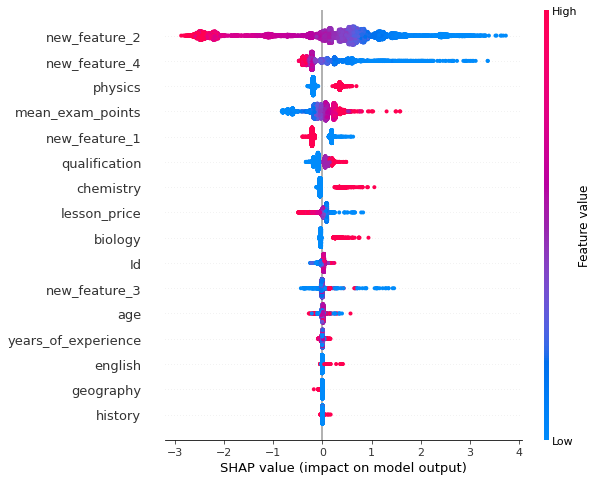

In [63]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

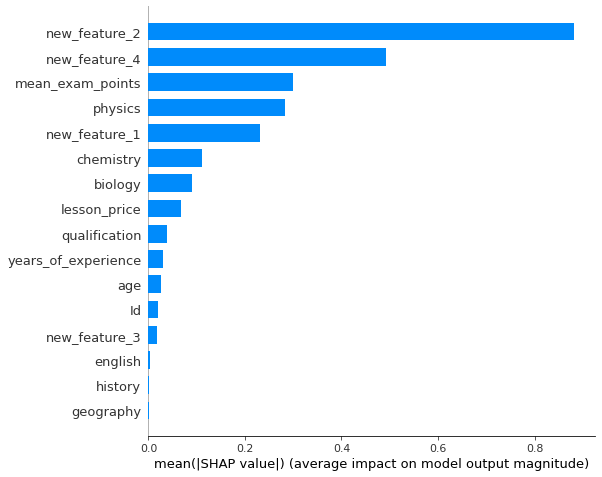

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Судя по полученным визуализациям, топ 5 признаков, влияющих на решение модели: new_feature_2, new_feature_4, mean_exam_points, physics, new_feature_1. 3 из 5 топ признаков получены в рамках feature engineering. 

Основываясь на визуализации также можно сказать, что хорошей разделяющей способностью обладают первые топ-9 признаков (до biology включительно).  Они хорошо разделяют данные по вероятности отнесения объектов к 0 или 1 в зависимости от значния признака. 

Проведем анализ для 10% выборки

In [64]:
shap.initjs()
explainer = shap.TreeExplainer(cb_model)

n = 800
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:], link='logit')


Если установить фильтр графика на sample order by output value, то он будет упорядочен по прогнозу вероятности, которую выдает модель на каждом объекте. На графике видны несколько объектов, которые можно пристально посмотреть на предмет признания их выбросами. Но в целом все выглядит достаточно логично.

# 6.для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Посмотрим на один объект из трейна. Используем link="logit", чтобы выводить вероятность, которую на данном объекте предсказывает модель. Смотрим на 10-й объект из трейна.

In [60]:
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:], link="logit")

Общая вероятость отнесения данного объекта к классу 1 равна всего 0.01 (1%). 

Факторы, которые сдвигали вероятность к 1: а) отношение стомиости часа репетитора к среднему баллу его учеников (new_feature_2) = 20.15 и составляющие этой метрики по отдельности б) стоимость часа репетитора (1350), в) среднее значение баллов у учеников = 67

Основные факторы, которые сдвигали вероятность к 0: а) отношение стоимости часа к квалификации репетитора (new_feature_4) = 1350, б) факт того, что данный репетитор преподает только математику без доп предметов (new_feature_1 = 1), в) в т.ч. он не преподает физику (physics=0), г) базовый уровень квалификации ( qualification = 1) 

Посмотрим на 1 объект из тестовой выборки. Выберем 719-й объект из тестовой выборки.

In [61]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[719,:], X_test.iloc[719,:], link="logit")

Общая вероятость отнесения данного объекта к классу 1 равна 0.76 (76%).

Факторы, которые сдвигали вероятность к 1: а) отношение стоимости часа репетитора к среднему баллу его учеников (new_feature_2) = 9.649 б) низкая стоимость часа репетитора (550), в) отношение стоимости часа к квалификации репетитора (new_feature_4) = 550 (маленькое значение показателя), г) возраст = 68 лет

Основные факторы, которые сдвигали вероятность к 0: а)  среднее значение баллов у учеников = 57, б) факт того, что данный репетитор преподает только математику без доп предметов (new_feature_1 = 1), в) в т.ч. он не преподает физику (physics=0),